In [39]:
# =====================================================
#     Tên: Real Estate Price Prediction
#     Nghiên cứu khoa học: "Nghiên cứu tối ưu mô hình kết hợp
#     trong việc dự đoán giá nhà tại Hà Nội"
#     Mô hình sử dụng: Radom Forest & XGBoost
# =====================================================

In [40]:
# -------------------------------------------------
# 0. CÀI THƯ VIỆN (Colab cài mới nhất đã hỗ trợ GPU)
# -------------------------------------------------
#!pip install -U xgboost optuna --quiet

In [ ]:
# -------------------------------------------------
# 1. IMPORT & ĐỌC DỮ LIỆU
# -------------------------------------------------
import pandas as pd
import numpy as np
from pathlib import Path

# --- tải/đọc CSV ---
DATA_PATH = Path("data_processing.csv")
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Không tìm thấy file: {DATA_PATH}")
data = pd.read_csv(DATA_PATH)

target = "price"
y = data[target]
X = data.drop(columns=[target])

In [42]:
# -------------------------------------------------
# 2. TIỀN XỬ LÝ: ColumnTransformer + Pipeline
# -------------------------------------------------
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_cols  = X.select_dtypes(include=["int64", "float64"]).columns
bool_cols = X.select_dtypes(include=["bool"]).columns  # 1‑hot district

preprocess = ColumnTransformer([
    ("num",  StandardScaler(),   num_cols),
    ("bool", "passthrough",      bool_cols)  # giữ nguyên 0/1
])

In [43]:
# -------------------------------------------------
# 3. ĐỊNH NGHĨA RMSLE & SCORER
# -------------------------------------------------
from sklearn.metrics import make_scorer, mean_squared_log_error

def rmsle(y_true, y_pred):
    # Cắt giá trị về >= 0 để tránh log(âm)
    y_true = np.clip(y_true, 0, None)
    y_pred = np.clip(y_pred, 0, None)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Tạo scorer cho cross_val_score,
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [44]:
# -------------------------------------------------
# 4. TÁCH TRAIN / TEST (80 % / 20 %)
# -------------------------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [45]:
# -------------------------------------------------
# 5. OPTUNA: TUNE XGBOOST GPU
# -------------------------------------------------
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        "n_estimators"     : trial.suggest_int("n_estimators", 300, 1500),
        "max_depth"        : trial.suggest_int("max_depth", 4, 18),
        "learning_rate"    : trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample"        : trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma"            : trial.suggest_float("gamma", 0, 5.0),
        "reg_alpha"        : trial.suggest_float("reg_alpha", 0.1, 10.0, log=True),
        "reg_lambda"       : trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
        "min_child_weight" : trial.suggest_float("min_child_weight", 1, 20),
        # --- BẬT GPU ---
        "tree_method"      : "gpu_hist",
        "predictor"        : "gpu_predictor",
        "gpu_id"           : 0,
        "random_state"     : 42,
    }

    model = Pipeline([
        ("prep", preprocess),
        ("xgb",  XGBRegressor(**params))
    ])

    # cross‑val 5 fold, tối thiểu RMSLE
    score = -cross_val_score(model, X_train, y_train,
                             cv=5,
                             scoring=rmsle_scorer,
                             n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Best RMSLE (CV):", study.best_value)
print("Best params:", study.best_params)

[I 2025-05-10 10:25:05,954] A new study created in memory with name: no-name-b4a6c75a-0798-496a-b41a-ab0f0df2c5fb


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:25:07] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:25:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:25:07] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:25:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist

[I 2025-05-10 10:25:35,660] Trial 0 finished with value: 0.3859223864040156 and parameters: {'n_estimators': 628, 'max_depth': 13, 'learning_rate': 0.02421626235019022, 'subsample': 0.7711830224232666, 'colsample_bytree': 0.7924556832117509, 'gamma': 1.6776850647465857, 'reg_alpha': 1.4007995582811408, 'reg_lambda': 0.6003961359991401, 'min_child_weight': 17.460188761531022}. Best is trial 0 with value: 0.3859223864040156.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:25:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:25:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:25:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:25:35] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:26:26,161] Trial 1 finished with value: 0.3370435755117325 and parameters: {'n_estimators': 1419, 'max_depth': 11, 'learning_rate': 0.025101893821047463, 'subsample': 0.8222015842318979, 'colsample_bytree': 0.8356538758865936, 'gamma': 2.969785327760055, 'reg_alpha': 0.33944090203819266, 'reg_lambda': 2.9797179245693255, 'min_child_weight': 9.033233195961664}. Best is trial 1 with value: 0.3370435755117325.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:26:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:26:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:26:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:26:26] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:27:16,295] Trial 2 finished with value: 0.33691717476411304 and parameters: {'n_estimators': 1228, 'max_depth': 13, 'learning_rate': 0.05577129615287326, 'subsample': 0.6985732083346948, 'colsample_bytree': 0.9869250911468697, 'gamma': 4.706262690801097, 'reg_alpha': 2.9970964578561543, 'reg_lambda': 5.297664338784867, 'min_child_weight': 9.212639624942813}. Best is trial 2 with value: 0.33691717476411304.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:27:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:27:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:27:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:27:16] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:28:20,187] Trial 3 finished with value: 0.31943120517852763 and parameters: {'n_estimators': 1447, 'max_depth': 13, 'learning_rate': 0.011905018038915811, 'subsample': 0.8473806286302921, 'colsample_bytree': 0.8716517279038709, 'gamma': 0.8404963890179673, 'reg_alpha': 1.612552977557502, 'reg_lambda': 8.912749480316146, 'min_child_weight': 9.428985097778666}. Best is trial 3 with value: 0.31943120517852763.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:28:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:28:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:28:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:28:20] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:28:53,832] Trial 4 finished with value: 0.43376635855188395 and parameters: {'n_estimators': 756, 'max_depth': 14, 'learning_rate': 0.18373990107834048, 'subsample': 0.6906496452373361, 'colsample_bytree': 0.9389511289968104, 'gamma': 4.033090062991185, 'reg_alpha': 6.027962224787956, 'reg_lambda': 1.1309748696772, 'min_child_weight': 14.756920030667107}. Best is trial 3 with value: 0.31943120517852763.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:28:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:28:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:28:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:28:54] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:29:13,079] Trial 5 finished with value: 0.3297761846207761 and parameters: {'n_estimators': 1011, 'max_depth': 5, 'learning_rate': 0.05938683961042806, 'subsample': 0.8279067650937616, 'colsample_bytree': 0.6119179093532703, 'gamma': 1.2255078828882877, 'reg_alpha': 0.1517032223100022, 'reg_lambda': 0.22717846360842714, 'min_child_weight': 5.730404006216387}. Best is trial 3 with value: 0.31943120517852763.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:29:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:29:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:29:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:29:13] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:29:59,427] Trial 6 finished with value: 0.4876367250309707 and parameters: {'n_estimators': 866, 'max_depth': 17, 'learning_rate': 0.1535131552470541, 'subsample': 0.9252763093633369, 'colsample_bytree': 0.677873118986686, 'gamma': 1.4818368576824654, 'reg_alpha': 0.47044377826780015, 'reg_lambda': 1.196329791336662, 'min_child_weight': 14.497211363669019}. Best is trial 3 with value: 0.31943120517852763.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:29:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:29:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:29:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:29:59] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:31:01,897] Trial 7 finished with value: 0.3693672113163528 and parameters: {'n_estimators': 1138, 'max_depth': 18, 'learning_rate': 0.038448146262589036, 'subsample': 0.9759674729525672, 'colsample_bytree': 0.9941800245304849, 'gamma': 0.546099560993889, 'reg_alpha': 4.791820927136321, 'reg_lambda': 1.4345864448434165, 'min_child_weight': 18.655949040665735}. Best is trial 3 with value: 0.31943120517852763.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:31:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:31:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:31:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:31:02] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:31:50,644] Trial 8 finished with value: 0.4204545076080943 and parameters: {'n_estimators': 923, 'max_depth': 17, 'learning_rate': 0.09443224303933977, 'subsample': 0.7414336339926177, 'colsample_bytree': 0.8268416722045531, 'gamma': 4.498647788728141, 'reg_alpha': 0.15499968386068863, 'reg_lambda': 5.354032113468031, 'min_child_weight': 12.537633948949335}. Best is trial 3 with value: 0.31943120517852763.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:31:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:31:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:31:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:31:50] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:32:20,343] Trial 9 finished with value: 0.29789108346884424 and parameters: {'n_estimators': 1378, 'max_depth': 6, 'learning_rate': 0.02726447974588004, 'subsample': 0.7402531433872337, 'colsample_bytree': 0.9651432278837534, 'gamma': 4.2349314747105105, 'reg_alpha': 0.15066006187190542, 'reg_lambda': 0.527612797317954, 'min_child_weight': 6.601419276887198}. Best is trial 9 with value: 0.29789108346884424.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:32:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:32:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:32:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:32:20] WARNING: /workspace/src/common/error_ms

[I 2025-05-10 10:32:25,979] Trial 10 finished with value: 0.3946671348851353 and parameters: {'n_estimators': 309, 'max_depth': 4, 'learning_rate': 0.010822984204637884, 'subsample': 0.6004360220326094, 'colsample_bytree': 0.7341375835211735, 'gamma': 3.3643854616117115, 'reg_alpha': 0.10162943071614276, 'reg_lambda': 0.1259651215593382, 'min_child_weight': 1.815017198690934}. Best is trial 9 with value: 0.29789108346884424.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:32:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:32:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:32:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:32:26] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:33:01,453] Trial 11 finished with value: 0.28037717060155004 and parameters: {'n_estimators': 1447, 'max_depth': 7, 'learning_rate': 0.012816241976587813, 'subsample': 0.8686457280868236, 'colsample_bytree': 0.8983101143321638, 'gamma': 0.010943159289884097, 'reg_alpha': 1.3339860075642862, 'reg_lambda': 0.371219679968902, 'min_child_weight': 5.046232311440587}. Best is trial 11 with value: 0.28037717060155004.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:33:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:33:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:33:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:33:01] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:33:33,260] Trial 12 finished with value: 0.2782497234146304 and parameters: {'n_estimators': 1290, 'max_depth': 7, 'learning_rate': 0.01918035014668088, 'subsample': 0.8768550690372645, 'colsample_bytree': 0.9124249928998864, 'gamma': 0.00850706657976772, 'reg_alpha': 0.6138926267602695, 'reg_lambda': 0.4058000250854928, 'min_child_weight': 4.275397685042011}. Best is trial 12 with value: 0.2782497234146304.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:33:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:33:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:33:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:33:33] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:34:09,500] Trial 13 finished with value: 0.254719769644443 and parameters: {'n_estimators': 1231, 'max_depth': 8, 'learning_rate': 0.014876773873416857, 'subsample': 0.8968562330274648, 'colsample_bytree': 0.9028080165072782, 'gamma': 0.07241598039965125, 'reg_alpha': 0.7079722291813614, 'reg_lambda': 0.3142823667940359, 'min_child_weight': 2.724384528228396}. Best is trial 13 with value: 0.254719769644443.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:34:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:34:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:34:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:34:09] WARNING: /workspace/src/common/error_ms

[I 2025-05-10 10:34:48,136] Trial 14 finished with value: 0.2481161530949964 and parameters: {'n_estimators': 1198, 'max_depth': 8, 'learning_rate': 0.018292991899502304, 'subsample': 0.9104912843723927, 'colsample_bytree': 0.8906790734668358, 'gamma': 0.013715784640322422, 'reg_alpha': 0.6004370730975296, 'reg_lambda': 0.10240976063754448, 'min_child_weight': 1.8815399647599107}. Best is trial 14 with value: 0.2481161530949964.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:34:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:34:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:34:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:34:48] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:35:01,386] Trial 15 finished with value: 0.30180328739248036 and parameters: {'n_estimators': 1121, 'max_depth': 9, 'learning_rate': 0.2932961069614326, 'subsample': 0.9925410925708589, 'colsample_bytree': 0.7911599414243947, 'gamma': 2.3766151530481516, 'reg_alpha': 0.8067931404884404, 'reg_lambda': 0.11470279320793207, 'min_child_weight': 1.022862389502878}. Best is trial 14 with value: 0.2481161530949964.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:35:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:35:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:35:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:35:01] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:35:37,152] Trial 16 finished with value: 0.27646932895642595 and parameters: {'n_estimators': 1081, 'max_depth': 9, 'learning_rate': 0.01693696039620522, 'subsample': 0.9171892531638507, 'colsample_bytree': 0.870184177985708, 'gamma': 2.084608968418435, 'reg_alpha': 0.3151262621640003, 'reg_lambda': 0.20164623549508764, 'min_child_weight': 3.142858720196245}. Best is trial 14 with value: 0.2481161530949964.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:35:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:35:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:35:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:35:37] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:36:15,905] Trial 17 finished with value: 0.33428089670623706 and parameters: {'n_estimators': 1251, 'max_depth': 9, 'learning_rate': 0.03854134506571881, 'subsample': 0.9302025652836429, 'colsample_bytree': 0.7413169361392166, 'gamma': 0.6178669919791364, 'reg_alpha': 2.444278109345915, 'reg_lambda': 0.19776034700894965, 'min_child_weight': 7.8019501404663245}. Best is trial 14 with value: 0.2481161530949964.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:36:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:36:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:36:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:36:16] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:36:41,949] Trial 18 finished with value: 0.2680775946973345 and parameters: {'n_estimators': 580, 'max_depth': 11, 'learning_rate': 0.016716856483323408, 'subsample': 0.896884665127307, 'colsample_bytree': 0.9254838354337983, 'gamma': 0.9037057466099476, 'reg_alpha': 0.8877157254654932, 'reg_lambda': 0.1032531186997035, 'min_child_weight': 3.245050995472403}. Best is trial 14 with value: 0.2481161530949964.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:36:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:36:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:36:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:36:42] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:37:09,345] Trial 19 finished with value: 0.33955092266462733 and parameters: {'n_estimators': 994, 'max_depth': 8, 'learning_rate': 0.0397463991189325, 'subsample': 0.9558462938007974, 'colsample_bytree': 0.8703335679694559, 'gamma': 0.2768242429803798, 'reg_alpha': 9.577497507139714, 'reg_lambda': 0.24338421243745656, 'min_child_weight': 11.984996643699574}. Best is trial 14 with value: 0.2481161530949964.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:37:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:37:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:37:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:37:09] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:37:39,460] Trial 20 finished with value: 0.28580036358518907 and parameters: {'n_estimators': 1300, 'max_depth': 10, 'learning_rate': 0.08374854985497533, 'subsample': 0.7781074555681962, 'colsample_bytree': 0.9495575504588889, 'gamma': 2.0344587341200704, 'reg_alpha': 0.3222561517614058, 'reg_lambda': 0.7703520656095573, 'min_child_weight': 2.543422610589268}. Best is trial 14 with value: 0.2481161530949964.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:37:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:37:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:37:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:37:39] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:38:02,107] Trial 21 finished with value: 0.2725862464087375 and parameters: {'n_estimators': 489, 'max_depth': 11, 'learning_rate': 0.015452125239315538, 'subsample': 0.9031892634657974, 'colsample_bytree': 0.9148407368430317, 'gamma': 1.00338224971464, 'reg_alpha': 0.8348053348328781, 'reg_lambda': 0.11831272788507695, 'min_child_weight': 4.002872978795348}. Best is trial 14 with value: 0.2481161530949964.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:38:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:38:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:38:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:38:02] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:38:22,320] Trial 22 finished with value: 0.24285425587139775 and parameters: {'n_estimators': 744, 'max_depth': 7, 'learning_rate': 0.010073046903843554, 'subsample': 0.8847501333669181, 'colsample_bytree': 0.8441293165525467, 'gamma': 0.7034633418675049, 'reg_alpha': 0.5769907127319476, 'reg_lambda': 0.10315628207346045, 'min_child_weight': 1.155452090157079}. Best is trial 22 with value: 0.24285425587139775.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:38:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:38:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:38:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:38:22] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:38:39,919] Trial 23 finished with value: 0.2550811339502851 and parameters: {'n_estimators': 754, 'max_depth': 6, 'learning_rate': 0.010259234165444771, 'subsample': 0.9561329111546261, 'colsample_bytree': 0.8324805587261279, 'gamma': 0.4465698974562474, 'reg_alpha': 0.45748773963976247, 'reg_lambda': 0.3109384845664195, 'min_child_weight': 1.0726537949069939}. Best is trial 22 with value: 0.24285425587139775.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:38:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:38:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:38:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:38:40] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:39:00,430] Trial 24 finished with value: 0.28941978981668554 and parameters: {'n_estimators': 823, 'max_depth': 7, 'learning_rate': 0.021488243313509754, 'subsample': 0.8662802105305449, 'colsample_bytree': 0.8831106245478422, 'gamma': 1.3271597848852124, 'reg_alpha': 0.5691481131970182, 'reg_lambda': 0.16151554140384747, 'min_child_weight': 6.581294212699708}. Best is trial 22 with value: 0.24285425587139775.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:39:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:39:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:39:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:39:00] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:39:20,119] Trial 25 finished with value: 0.2867148960101417 and parameters: {'n_estimators': 1180, 'max_depth': 4, 'learning_rate': 0.013841268903952111, 'subsample': 0.9460537918494989, 'colsample_bytree': 0.8452188729470498, 'gamma': 0.20349935107360745, 'reg_alpha': 0.22731547332366062, 'reg_lambda': 0.15249237966637919, 'min_child_weight': 2.6911070764755145}. Best is trial 22 with value: 0.24285425587139775.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:39:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:39:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:39:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:39:20] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:39:48,519] Trial 26 finished with value: 0.30554441853957703 and parameters: {'n_estimators': 1028, 'max_depth': 8, 'learning_rate': 0.03335607653559116, 'subsample': 0.8179290051259894, 'colsample_bytree': 0.7596702583265532, 'gamma': 0.5912683340656798, 'reg_alpha': 1.1362804841085083, 'reg_lambda': 0.2765149928400742, 'min_child_weight': 5.495539845906351}. Best is trial 22 with value: 0.24285425587139775.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:39:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:39:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:39:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:39:48] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:40:03,162] Trial 27 finished with value: 0.26464495964042073 and parameters: {'n_estimators': 645, 'max_depth': 6, 'learning_rate': 0.014432732508183227, 'subsample': 0.8955915705806262, 'colsample_bytree': 0.8099312224871544, 'gamma': 1.6863463086843438, 'reg_alpha': 1.979701701624797, 'reg_lambda': 1.8170926606255873, 'min_child_weight': 3.955481772284503}. Best is trial 22 with value: 0.24285425587139775.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:40:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:40:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:40:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:40:03] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:40:30,925] Trial 28 finished with value: 0.24624958080873638 and parameters: {'n_estimators': 934, 'max_depth': 8, 'learning_rate': 0.010334242667866908, 'subsample': 0.8540799774949906, 'colsample_bytree': 0.9624393805508872, 'gamma': 2.9132304023453743, 'reg_alpha': 0.6803692455121194, 'reg_lambda': 0.1637068853197836, 'min_child_weight': 2.0422878768603585}. Best is trial 22 with value: 0.24285425587139775.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:40:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:40:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:40:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:40:31] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:40:57,397] Trial 29 finished with value: 0.27652217281366276 and parameters: {'n_estimators': 709, 'max_depth': 10, 'learning_rate': 0.010051198989636152, 'subsample': 0.7999387608686003, 'colsample_bytree': 0.9717917236593383, 'gamma': 3.200089466811731, 'reg_alpha': 0.3843712651221306, 'reg_lambda': 0.5659299698792738, 'min_child_weight': 6.942913695349125}. Best is trial 22 with value: 0.24285425587139775.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:40:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:40:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:40:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:40:57] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:41:15,600] Trial 30 finished with value: 0.2591855820835086 and parameters: {'n_estimators': 924, 'max_depth': 5, 'learning_rate': 0.020954708495896132, 'subsample': 0.8438408040899332, 'colsample_bytree': 0.939105976248573, 'gamma': 2.753183751354497, 'reg_alpha': 1.0799284838053507, 'reg_lambda': 0.1625302774468736, 'min_child_weight': 1.7177243721180384}. Best is trial 22 with value: 0.24285425587139775.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:41:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:41:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:41:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:41:15] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:41:33,720] Trial 31 finished with value: 0.24924988720167543 and parameters: {'n_estimators': 585, 'max_depth': 8, 'learning_rate': 0.013193368676030567, 'subsample': 0.8795793453489895, 'colsample_bytree': 0.8984819019654501, 'gamma': 3.6485485610900223, 'reg_alpha': 0.568983445661415, 'reg_lambda': 0.10294035917283231, 'min_child_weight': 2.395880669272054}. Best is trial 22 with value: 0.24285425587139775.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:41:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:41:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:41:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:41:33] WARNING: /workspace/src/common/error_ms

[I 2025-05-10 10:41:54,410] Trial 32 finished with value: 0.27605292969779555 and parameters: {'n_estimators': 486, 'max_depth': 10, 'learning_rate': 0.012051946073825037, 'subsample': 0.8580667140090379, 'colsample_bytree': 0.8515160847789072, 'gamma': 3.6633542438784574, 'reg_alpha': 0.5381575323222834, 'reg_lambda': 0.10470786420406548, 'min_child_weight': 4.566041360153516}. Best is trial 22 with value: 0.24285425587139775.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:41:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:41:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:41:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:41:54] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:42:11,030] Trial 33 finished with value: 0.26527013636735697 and parameters: {'n_estimators': 557, 'max_depth': 8, 'learning_rate': 0.025867198190102345, 'subsample': 0.8072166843139765, 'colsample_bytree': 0.8038577107224175, 'gamma': 3.8970607791067726, 'reg_alpha': 0.25158230889867017, 'reg_lambda': 0.154147202831501, 'min_child_weight': 2.080743387702488}. Best is trial 22 with value: 0.24285425587139775.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:42:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:42:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:42:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:42:11] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:42:34,457] Trial 34 finished with value: 0.24073058668973463 and parameters: {'n_estimators': 359, 'max_depth': 12, 'learning_rate': 0.01817295382449673, 'subsample': 0.8436839652234202, 'colsample_bytree': 0.9630208580816436, 'gamma': 2.7863010338587797, 'reg_alpha': 0.4201720581586653, 'reg_lambda': 0.1394532347676818, 'min_child_weight': 1.0876267302047866}. Best is trial 34 with value: 0.24073058668973463.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:42:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:42:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:42:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:42:34] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:42:55,992] Trial 35 finished with value: 0.2496359480828425 and parameters: {'n_estimators': 319, 'max_depth': 14, 'learning_rate': 0.02882196075712526, 'subsample': 0.8398302749034141, 'colsample_bytree': 0.979010584663599, 'gamma': 2.720997137240059, 'reg_alpha': 1.5536778113022383, 'reg_lambda': 0.18155093441733863, 'min_child_weight': 1.0318200729616487}. Best is trial 34 with value: 0.24073058668973463.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:42:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:42:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:42:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:42:56] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:43:17,555] Trial 36 finished with value: 0.2669573869305004 and parameters: {'n_estimators': 403, 'max_depth': 12, 'learning_rate': 0.018318664592772, 'subsample': 0.7879250464015578, 'colsample_bytree': 0.9530875996854612, 'gamma': 2.3435115399634263, 'reg_alpha': 0.40654492708976697, 'reg_lambda': 0.13617786784690672, 'min_child_weight': 3.656392778051285}. Best is trial 34 with value: 0.24073058668973463.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:43:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:43:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:43:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:43:17] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:43:51,074] Trial 37 finished with value: 0.3498607043122223 and parameters: {'n_estimators': 802, 'max_depth': 13, 'learning_rate': 0.046945925317387116, 'subsample': 0.7516840097195211, 'colsample_bytree': 0.9324464264324974, 'gamma': 3.072406550814259, 'reg_alpha': 0.28341639074610225, 'reg_lambda': 2.770215533833148, 'min_child_weight': 10.4931359152404}. Best is trial 34 with value: 0.24073058668973463.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:43:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:43:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:43:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:43:51] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:44:24,654] Trial 38 finished with value: 0.3298761492057569 and parameters: {'n_estimators': 657, 'max_depth': 15, 'learning_rate': 0.02044278963707044, 'subsample': 0.8321867852392504, 'colsample_bytree': 0.9920209607248912, 'gamma': 1.8209066739413553, 'reg_alpha': 1.144974647212814, 'reg_lambda': 0.7688929513690845, 'min_child_weight': 15.46382869751924}. Best is trial 34 with value: 0.24073058668973463.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:44:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:44:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:44:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:44:24] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:45:21,828] Trial 39 finished with value: 0.3040809995771369 and parameters: {'n_estimators': 1359, 'max_depth': 12, 'learning_rate': 0.012017377128177015, 'subsample': 0.9279936870971283, 'colsample_bytree': 0.9983240397021954, 'gamma': 2.7562631401546356, 'reg_alpha': 0.21473338536467065, 'reg_lambda': 0.23696391197580843, 'min_child_weight': 8.600713391757028}. Best is trial 34 with value: 0.24073058668973463.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:45:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:45:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:45:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:45:22] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:46:02,355] Trial 40 finished with value: 0.3516538867423513 and parameters: {'n_estimators': 938, 'max_depth': 12, 'learning_rate': 0.025016318642484443, 'subsample': 0.7599147213543614, 'colsample_bytree': 0.6278938414444186, 'gamma': 2.524358730963835, 'reg_alpha': 0.7024198136407553, 'reg_lambda': 0.47139623481133397, 'min_child_weight': 5.875866707600605}. Best is trial 34 with value: 0.24073058668973463.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:46:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:46:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:46:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:46:02] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:46:14,706] Trial 41 finished with value: 0.2521164659981191 and parameters: {'n_estimators': 452, 'max_depth': 7, 'learning_rate': 0.013104060546289984, 'subsample': 0.8800231218677564, 'colsample_bytree': 0.8865460978841733, 'gamma': 3.585065186668947, 'reg_alpha': 0.49429708175125425, 'reg_lambda': 0.10596135149657115, 'min_child_weight': 2.09002728066241}. Best is trial 34 with value: 0.24073058668973463.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:46:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:46:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:46:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:46:14] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:46:42,761] Trial 42 finished with value: 0.2442040157211133 and parameters: {'n_estimators': 708, 'max_depth': 9, 'learning_rate': 0.01023550470296327, 'subsample': 0.8567808294798597, 'colsample_bytree': 0.8631178530641935, 'gamma': 3.409883744993838, 'reg_alpha': 0.6284155441238861, 'reg_lambda': 0.1288531814702278, 'min_child_weight': 1.833655238517204}. Best is trial 34 with value: 0.24073058668973463.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:46:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:46:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:46:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:46:43] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:47:12,547] Trial 43 finished with value: 0.24458919516933642 and parameters: {'n_estimators': 761, 'max_depth': 9, 'learning_rate': 0.010277858078959118, 'subsample': 0.8540296741540236, 'colsample_bytree': 0.8548258251781955, 'gamma': 3.383929883709982, 'reg_alpha': 0.38754566353670117, 'reg_lambda': 0.13121665767835297, 'min_child_weight': 1.6667044106298037}. Best is trial 34 with value: 0.24073058668973463.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:47:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:47:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:47:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:47:12] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:47:46,913] Trial 44 finished with value: 0.28001857400786767 and parameters: {'n_estimators': 863, 'max_depth': 10, 'learning_rate': 0.010109591741126163, 'subsample': 0.8509451439233495, 'colsample_bytree': 0.7803562695948202, 'gamma': 3.4628399486556227, 'reg_alpha': 0.422690131810943, 'reg_lambda': 0.13718527860464436, 'min_child_weight': 3.4097486119189835}. Best is trial 34 with value: 0.24073058668973463.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:47:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:47:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:47:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:47:47] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:48:11,323] Trial 45 finished with value: 0.27119393847633155 and parameters: {'n_estimators': 714, 'max_depth': 9, 'learning_rate': 0.011205870083041953, 'subsample': 0.8175957774197478, 'colsample_bytree': 0.8577205158326343, 'gamma': 2.9549152266460887, 'reg_alpha': 0.7099833717197285, 'reg_lambda': 0.19273786029231418, 'min_child_weight': 4.741650846874094}. Best is trial 34 with value: 0.24073058668973463.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:48:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:48:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:48:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:48:11] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:48:53,077] Trial 46 finished with value: 0.26065877145026056 and parameters: {'n_estimators': 801, 'max_depth': 11, 'learning_rate': 0.012015346757968844, 'subsample': 0.8342432977338178, 'colsample_bytree': 0.8195759503371892, 'gamma': 4.268456585639196, 'reg_alpha': 0.17849085961319006, 'reg_lambda': 0.26991649316275673, 'min_child_weight': 1.4965275608232116}. Best is trial 34 with value: 0.24073058668973463.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:48:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:48:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:48:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:48:53] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:49:13,650] Trial 47 finished with value: 0.4334044074567248 and parameters: {'n_estimators': 702, 'max_depth': 9, 'learning_rate': 0.06859641798122479, 'subsample': 0.6936969354335322, 'colsample_bytree': 0.6951058018625613, 'gamma': 3.2429895172551695, 'reg_alpha': 0.36783104726413374, 'reg_lambda': 0.14156185562415513, 'min_child_weight': 17.225673394446876}. Best is trial 34 with value: 0.24073058668973463.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:49:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:49:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:49:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:49:13] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:49:33,376] Trial 48 finished with value: 0.3105527022445712 and parameters: {'n_estimators': 870, 'max_depth': 6, 'learning_rate': 0.11558370196257883, 'subsample': 0.6534131541595669, 'colsample_bytree': 0.9588992682977933, 'gamma': 4.7824658489964085, 'reg_alpha': 3.434776474128113, 'reg_lambda': 0.21454676810530238, 'min_child_weight': 3.1281012250300932}. Best is trial 34 with value: 0.24073058668973463.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:49:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:49:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:49:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:49:33] WARNING: /workspace/src/common/error_ms

[I 2025-05-10 10:49:41,100] Trial 49 finished with value: 0.2973552774185523 and parameters: {'n_estimators': 375, 'max_depth': 5, 'learning_rate': 0.015421631270351618, 'subsample': 0.8578646163777117, 'colsample_bytree': 0.7819214141602175, 'gamma': 3.985173879202325, 'reg_alpha': 0.9704676676004541, 'reg_lambda': 0.3397181293065118, 'min_child_weight': 5.251756133701115}. Best is trial 34 with value: 0.24073058668973463.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:49:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:49:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:49:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:49:41] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:50:47,546] Trial 50 finished with value: 0.2663442132849762 and parameters: {'n_estimators': 992, 'max_depth': 15, 'learning_rate': 0.011605102751860856, 'subsample': 0.7954087638811259, 'colsample_bytree': 0.8428455402308771, 'gamma': 2.9412833415832322, 'reg_alpha': 1.3015363571117193, 'reg_lambda': 8.67275072923932, 'min_child_weight': 1.033165301018995}. Best is trial 34 with value: 0.24073058668973463.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:50:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:50:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:50:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:50:47] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:51:07,858] Trial 51 finished with value: 0.24289756836499565 and parameters: {'n_estimators': 757, 'max_depth': 7, 'learning_rate': 0.017099366357978037, 'subsample': 0.9078051074824325, 'colsample_bytree': 0.8830282660864495, 'gamma': 3.3918107900988663, 'reg_alpha': 0.6370866593292007, 'reg_lambda': 0.12687339266697423, 'min_child_weight': 1.9554490755629488}. Best is trial 34 with value: 0.24073058668973463.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:51:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:51:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:51:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:51:08] WARNING: /workspace/src/common/error_ms

[I 2025-05-10 10:51:28,202] Trial 52 finished with value: 0.25323968943683123 and parameters: {'n_estimators': 766, 'max_depth': 7, 'learning_rate': 0.016307004658214053, 'subsample': 0.8852892565334836, 'colsample_bytree': 0.8631994250870486, 'gamma': 3.3535767308362257, 'reg_alpha': 0.6819043308861078, 'reg_lambda': 0.129918412616975, 'min_child_weight': 2.4195752302027866}. Best is trial 34 with value: 0.24073058668973463.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:51:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:51:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:51:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:51:28] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:51:50,621] Trial 53 finished with value: 0.2403863697143898 and parameters: {'n_estimators': 844, 'max_depth': 7, 'learning_rate': 0.013899746128533255, 'subsample': 0.8668027817167673, 'colsample_bytree': 0.9132729833086256, 'gamma': 3.7596786710645422, 'reg_alpha': 0.4859558393308535, 'reg_lambda': 0.17839960745429667, 'min_child_weight': 1.617454340282852}. Best is trial 53 with value: 0.2403863697143898.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:51:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:51:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:51:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:51:50] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:52:03,854] Trial 54 finished with value: 0.272410358572874 and parameters: {'n_estimators': 673, 'max_depth': 5, 'learning_rate': 0.013751963808240645, 'subsample': 0.9172233904223598, 'colsample_bytree': 0.9202305722538149, 'gamma': 4.461180846268308, 'reg_alpha': 0.3022226811519338, 'reg_lambda': 0.12520157972768048, 'min_child_weight': 3.0289225154048793}. Best is trial 53 with value: 0.2403863697143898.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:52:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:52:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:52:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:52:04] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:52:17,968] Trial 55 finished with value: 0.25090587891050836 and parameters: {'n_estimators': 604, 'max_depth': 6, 'learning_rate': 0.022953202384724414, 'subsample': 0.9401587223481335, 'colsample_bytree': 0.8770937528060461, 'gamma': 4.220984160208707, 'reg_alpha': 0.46104479079625854, 'reg_lambda': 0.18183656782382637, 'min_child_weight': 1.593201459157532}. Best is trial 53 with value: 0.2403863697143898.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:52:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:52:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:52:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:52:18] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:52:36,899] Trial 56 finished with value: 0.2606354903372973 and parameters: {'n_estimators': 747, 'max_depth': 7, 'learning_rate': 0.017499986312758495, 'subsample': 0.8689653706315098, 'colsample_bytree': 0.9050907868183139, 'gamma': 3.8472059456653818, 'reg_alpha': 0.10163087567794284, 'reg_lambda': 0.22401173294951482, 'min_child_weight': 3.474552895266477}. Best is trial 53 with value: 0.2403863697143898.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:52:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:52:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:52:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:52:37] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:52:56,116] Trial 57 finished with value: 0.2675591702242827 and parameters: {'n_estimators': 544, 'max_depth': 9, 'learning_rate': 0.015092673194793906, 'subsample': 0.8950864295661687, 'colsample_bytree': 0.8196606083287293, 'gamma': 3.745836844544665, 'reg_alpha': 0.33826472503022387, 'reg_lambda': 0.13089131576928537, 'min_child_weight': 3.8602808359561207}. Best is trial 53 with value: 0.2403863697143898.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:52:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:52:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:52:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:52:56] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:53:23,061] Trial 58 finished with value: 0.38131239584790527 and parameters: {'n_estimators': 837, 'max_depth': 10, 'learning_rate': 0.03070226343811118, 'subsample': 0.824337465986986, 'colsample_bytree': 0.8333323963010507, 'gamma': 3.4670961531866014, 'reg_alpha': 0.8254171381289632, 'reg_lambda': 0.4084426506851416, 'min_child_weight': 19.31854934791488}. Best is trial 53 with value: 0.2403863697143898.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:53:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:53:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:53:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:53:23] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:53:42,102] Trial 59 finished with value: 0.320923242653036 and parameters: {'n_estimators': 775, 'max_depth': 7, 'learning_rate': 0.01919508856872228, 'subsample': 0.9853529169703564, 'colsample_bytree': 0.9421227650852038, 'gamma': 3.1445620546890827, 'reg_alpha': 0.5154513635707636, 'reg_lambda': 0.274540747901239, 'min_child_weight': 12.600402268511658}. Best is trial 53 with value: 0.2403863697143898.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:53:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:53:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:53:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:53:42] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:53:53,695] Trial 60 finished with value: 0.31701068530133825 and parameters: {'n_estimators': 527, 'max_depth': 13, 'learning_rate': 0.1797986315945048, 'subsample': 0.9080000384409944, 'colsample_bytree': 0.8908495162384281, 'gamma': 4.132057614248589, 'reg_alpha': 0.25410995796193486, 'reg_lambda': 0.11922139130999566, 'min_child_weight': 2.7606785841316324}. Best is trial 53 with value: 0.2403863697143898.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:53:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:53:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:53:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:53:53] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:54:22,901] Trial 61 finished with value: 0.23528595261780608 and parameters: {'n_estimators': 949, 'max_depth': 8, 'learning_rate': 0.011071138966349151, 'subsample': 0.8631977461752062, 'colsample_bytree': 0.9680033036460431, 'gamma': 2.922424855614134, 'reg_alpha': 0.63552139271201, 'reg_lambda': 0.16940453446227355, 'min_child_weight': 1.6942630057636836}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:54:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:54:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:54:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:54:23] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:54:53,035] Trial 62 finished with value: 0.2400965194058192 and parameters: {'n_estimators': 964, 'max_depth': 8, 'learning_rate': 0.011102316428433673, 'subsample': 0.8675347478746099, 'colsample_bytree': 0.9133930042575733, 'gamma': 2.167606025972212, 'reg_alpha': 0.6276884355597276, 'reg_lambda': 0.17592017381174874, 'min_child_weight': 1.6023216890340692}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:54:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:54:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:54:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:54:53] WARNING: /workspace/src/common/error_ms

[I 2025-05-10 10:55:20,729] Trial 63 finished with value: 0.23725311210329075 and parameters: {'n_estimators': 887, 'max_depth': 8, 'learning_rate': 0.01288118062693977, 'subsample': 0.8832793663633891, 'colsample_bytree': 0.927422084713217, 'gamma': 2.5358806179022944, 'reg_alpha': 0.9230665717049601, 'reg_lambda': 0.18251024782904468, 'min_child_weight': 1.3935079086094602}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:55:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:55:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:55:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:55:21] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:55:49,037] Trial 64 finished with value: 0.24056770757579918 and parameters: {'n_estimators': 1073, 'max_depth': 7, 'learning_rate': 0.01289730504569254, 'subsample': 0.8867338299234411, 'colsample_bytree': 0.9164639993045423, 'gamma': 2.482661496091483, 'reg_alpha': 0.9318803908371099, 'reg_lambda': 0.1903652020112554, 'min_child_weight': 1.0907534909578815}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:55:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:55:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:55:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:55:49] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:56:21,364] Trial 65 finished with value: 0.23866126693344575 and parameters: {'n_estimators': 1055, 'max_depth': 8, 'learning_rate': 0.01287461834555359, 'subsample': 0.8894507011079189, 'colsample_bytree': 0.9811992215243994, 'gamma': 2.4251887336548514, 'reg_alpha': 0.902320440452811, 'reg_lambda': 0.18407954175380142, 'min_child_weight': 1.0776447258883346}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:56:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:56:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:56:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:56:21] WARNING: /workspace/src/common/error_ms

[I 2025-05-10 10:56:52,456] Trial 66 finished with value: 0.25448669040754013 and parameters: {'n_estimators': 1061, 'max_depth': 8, 'learning_rate': 0.013507724290019788, 'subsample': 0.8707440346737191, 'colsample_bytree': 0.9800915125967855, 'gamma': 2.1881137529199357, 'reg_alpha': 0.9409552913673057, 'reg_lambda': 0.18168435115973727, 'min_child_weight': 2.6352846827861205}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:56:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:56:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:56:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:56:52] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:57:23,424] Trial 67 finished with value: 0.2649824970496496 and parameters: {'n_estimators': 1095, 'max_depth': 8, 'learning_rate': 0.011721299203257504, 'subsample': 0.8860725482053928, 'colsample_bytree': 0.9283104273727809, 'gamma': 2.5414683957366253, 'reg_alpha': 1.3466121381716134, 'reg_lambda': 0.25808489179422617, 'min_child_weight': 4.140764177475773}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:57:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:57:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:57:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:57:23] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:57:41,053] Trial 68 finished with value: 0.30662785351377353 and parameters: {'n_estimators': 974, 'max_depth': 5, 'learning_rate': 0.2996461226693644, 'subsample': 0.8133831230801227, 'colsample_bytree': 0.967349405716907, 'gamma': 2.255031649877608, 'reg_alpha': 0.7961082689949367, 'reg_lambda': 0.3046805405732029, 'min_child_weight': 1.454042544266201}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:57:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:57:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:57:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:57:41] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:58:07,836] Trial 69 finished with value: 0.2470760163525283 and parameters: {'n_estimators': 1179, 'max_depth': 6, 'learning_rate': 0.014599523553958313, 'subsample': 0.8924324028143287, 'colsample_bytree': 0.9459993683933328, 'gamma': 1.8842051024693873, 'reg_alpha': 2.109784124071982, 'reg_lambda': 0.2135633575410967, 'min_child_weight': 1.0200540650014138}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:58:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:58:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:58:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:58:08] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:58:36,685] Trial 70 finished with value: 0.2537780342955633 and parameters: {'n_estimators': 959, 'max_depth': 8, 'learning_rate': 0.012867679315463025, 'subsample': 0.9619428074924898, 'colsample_bytree': 0.9124806797944485, 'gamma': 2.6466287527279895, 'reg_alpha': 1.057910250861126, 'reg_lambda': 0.36965493064613886, 'min_child_weight': 2.4915910981186045}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:58:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:58:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:58:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:58:36] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:59:03,583] Trial 71 finished with value: 0.2378014141497113 and parameters: {'n_estimators': 1028, 'max_depth': 7, 'learning_rate': 0.011252659226375366, 'subsample': 0.8740020641657414, 'colsample_bytree': 0.9798166554233743, 'gamma': 2.4010932452974814, 'reg_alpha': 0.758991913454101, 'reg_lambda': 0.17234664026482352, 'min_child_weight': 1.0096499712407105}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:59:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:59:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:59:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:59:03] WARNING: /workspace/src/common/error_ms

[I 2025-05-10 10:59:26,976] Trial 72 finished with value: 0.2533961100218336 and parameters: {'n_estimators': 1042, 'max_depth': 6, 'learning_rate': 0.011386183778630885, 'subsample': 0.8707719463972886, 'colsample_bytree': 0.9831574000954438, 'gamma': 2.0928244351440224, 'reg_alpha': 0.8541872895560766, 'reg_lambda': 0.17933009481067252, 'min_child_weight': 2.187326073586135}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:59:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:59:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:59:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:59:27] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 10:59:56,759] Trial 73 finished with value: 0.24237961590500726 and parameters: {'n_estimators': 1137, 'max_depth': 7, 'learning_rate': 0.01591960808029972, 'subsample': 0.8410162879612954, 'colsample_bytree': 0.9710822138656606, 'gamma': 2.461914951403909, 'reg_alpha': 1.6682731645822124, 'reg_lambda': 0.20377191414786802, 'min_child_weight': 1.5417712551865252}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:59:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:59:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:59:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:59:57] WARNING: /workspace/src/common/error_ms

[I 2025-05-10 11:00:23,571] Trial 74 finished with value: 0.24938337891680584 and parameters: {'n_estimators': 894, 'max_depth': 8, 'learning_rate': 0.012608873741046179, 'subsample': 0.9244387838773963, 'colsample_bytree': 0.9552760154875536, 'gamma': 1.9027472659128257, 'reg_alpha': 0.7629251133920384, 'reg_lambda': 0.16817948760791787, 'min_child_weight': 2.7405982098976325}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:00:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:00:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:00:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:00:23] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 11:00:47,704] Trial 75 finished with value: 0.2605272504028348 and parameters: {'n_estimators': 1090, 'max_depth': 6, 'learning_rate': 0.013870267007965469, 'subsample': 0.9001193272389841, 'colsample_bytree': 0.927480861926151, 'gamma': 2.332953334816591, 'reg_alpha': 1.1734887871198938, 'reg_lambda': 0.2391129772234724, 'min_child_weight': 3.147690575396174}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:00:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:00:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:00:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:00:47] WARNING: /workspace/src/common/error_ms

[I 2025-05-10 11:01:29,407] Trial 76 finished with value: 0.2711738239064201 and parameters: {'n_estimators': 1014, 'max_depth': 11, 'learning_rate': 0.011217406599070305, 'subsample': 0.8636379418236738, 'colsample_bytree': 0.9887348359745753, 'gamma': 2.6299964453727926, 'reg_alpha': 0.9438756155509379, 'reg_lambda': 0.1515940032124055, 'min_child_weight': 4.4269743719494}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:01:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:01:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:01:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:01:29] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 11:01:56,973] Trial 77 finished with value: 0.2394199314457698 and parameters: {'n_estimators': 1052, 'max_depth': 7, 'learning_rate': 0.018627286924360997, 'subsample': 0.8761499687172309, 'colsample_bytree': 0.9386540313992828, 'gamma': 2.8120251393094464, 'reg_alpha': 1.5226182460993927, 'reg_lambda': 0.701803832896485, 'min_child_weight': 1.5363714922265055}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:01:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:01:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:01:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:01:57] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 11:02:23,692] Trial 78 finished with value: 0.2519613581007358 and parameters: {'n_estimators': 1046, 'max_depth': 7, 'learning_rate': 0.014557443898054585, 'subsample': 0.941073217192373, 'colsample_bytree': 0.9368872762053517, 'gamma': 2.019365575374534, 'reg_alpha': 1.7614737520052417, 'reg_lambda': 1.0160368694032076, 'min_child_weight': 2.0640605068341866}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:02:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:02:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:02:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:02:23] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 11:02:42,305] Trial 79 finished with value: 0.28256384686074076 and parameters: {'n_estimators': 1113, 'max_depth': 4, 'learning_rate': 0.019206250613900393, 'subsample': 0.9185986405799996, 'colsample_bytree': 0.9087113004988006, 'gamma': 1.5426760688874344, 'reg_alpha': 1.1965568126385804, 'reg_lambda': 1.5337079277495724, 'min_child_weight': 3.6427866402682336}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:02:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:02:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:02:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:02:42] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 11:03:09,300] Trial 80 finished with value: 0.24341798292965205 and parameters: {'n_estimators': 909, 'max_depth': 8, 'learning_rate': 0.023401538442609775, 'subsample': 0.8791127244152808, 'colsample_bytree': 0.9994615825102897, 'gamma': 2.8757788184099025, 'reg_alpha': 2.241325308713275, 'reg_lambda': 2.256341718185174, 'min_child_weight': 1.573413592412017}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:03:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:03:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:03:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:03:09] WARNING: /workspace/src/common/error_ms

[I 2025-05-10 11:03:39,186] Trial 81 finished with value: 0.2403707388725008 and parameters: {'n_estimators': 1155, 'max_depth': 7, 'learning_rate': 0.01234038098239503, 'subsample': 0.8410992966927603, 'colsample_bytree': 0.9517262870301374, 'gamma': 2.8130347050770967, 'reg_alpha': 0.5610224342268469, 'reg_lambda': 0.6662029759184218, 'min_child_weight': 1.0035378870550777}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:03:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:03:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:03:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:03:39] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 11:04:09,568] Trial 82 finished with value: 0.23823637657143823 and parameters: {'n_estimators': 1172, 'max_depth': 7, 'learning_rate': 0.012672316099170158, 'subsample': 0.8875151920654518, 'colsample_bytree': 0.9758914862393339, 'gamma': 2.398801525367996, 'reg_alpha': 0.5613819116578045, 'reg_lambda': 0.7606099422716738, 'min_child_weight': 1.4020442812388865}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:04:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:04:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:04:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:04:09] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 11:04:37,963] Trial 83 finished with value: 0.25684166650060447 and parameters: {'n_estimators': 1276, 'max_depth': 6, 'learning_rate': 0.015928835161355043, 'subsample': 0.8742779368446716, 'colsample_bytree': 0.9736283599221491, 'gamma': 4.940473957687919, 'reg_alpha': 0.5685371448578925, 'reg_lambda': 0.708871993303965, 'min_child_weight': 2.270146627857539}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:04:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:04:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:04:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:04:38] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 11:05:13,035] Trial 84 finished with value: 0.23949188473420566 and parameters: {'n_estimators': 1175, 'max_depth': 8, 'learning_rate': 0.010842220114216967, 'subsample': 0.8308388134063042, 'colsample_bytree': 0.948944272643382, 'gamma': 2.222710906053575, 'reg_alpha': 0.49825414182204014, 'reg_lambda': 0.6525909734706373, 'min_child_weight': 1.4460591954021516}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:05:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:05:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:05:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:05:13] WARNING: /workspace/src/common/error_ms

[I 2025-05-10 11:05:47,917] Trial 85 finished with value: 0.2475746889690787 and parameters: {'n_estimators': 1211, 'max_depth': 8, 'learning_rate': 0.01091669004681182, 'subsample': 0.8367882900203523, 'colsample_bytree': 0.9511295755173759, 'gamma': 2.3848786401359328, 'reg_alpha': 0.7384260800112237, 'reg_lambda': 0.6562300240793867, 'min_child_weight': 2.969822816815269}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:05:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:05:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:05:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:05:48] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 11:06:25,420] Trial 86 finished with value: 0.24829600843442243 and parameters: {'n_estimators': 1151, 'max_depth': 9, 'learning_rate': 0.012254930773575815, 'subsample': 0.8271919699463854, 'colsample_bytree': 0.9607006882244423, 'gamma': 2.191167714140364, 'reg_alpha': 0.6164657765589445, 'reg_lambda': 0.8508987880344553, 'min_child_weight': 2.163320951065514}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:06:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:06:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:06:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:06:25] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 11:06:42,708] Trial 87 finished with value: 0.2769968016754334 and parameters: {'n_estimators': 1332, 'max_depth': 8, 'learning_rate': 0.24967647474576304, 'subsample': 0.8470451155102903, 'colsample_bytree': 0.9873598569294715, 'gamma': 3.054089810278468, 'reg_alpha': 1.5607010721900543, 'reg_lambda': 0.4777432318275839, 'min_child_weight': 1.7748371680862514}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:06:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:06:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:06:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:06:42] WARNING: /workspace/src/common/error_ms

[I 2025-05-10 11:07:19,171] Trial 88 finished with value: 0.24006316671854172 and parameters: {'n_estimators': 1251, 'max_depth': 8, 'learning_rate': 0.010975013890193952, 'subsample': 0.7091919953652774, 'colsample_bytree': 0.9424821055920112, 'gamma': 1.7092851344673439, 'reg_alpha': 2.962468957562102, 'reg_lambda': 1.2334746335713813, 'min_child_weight': 1.4141821172013571}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:07:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:07:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:07:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:07:19] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 11:07:58,623] Trial 89 finished with value: 0.2583477503244095 and parameters: {'n_estimators': 1245, 'max_depth': 9, 'learning_rate': 0.010769854740176913, 'subsample': 0.6214297599703014, 'colsample_bytree': 0.9420009551878057, 'gamma': 1.6265473643741337, 'reg_alpha': 4.093759267593367, 'reg_lambda': 1.2452808030928892, 'min_child_weight': 2.4864012405718867}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:07:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:07:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:07:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:07:58] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 11:08:31,460] Trial 90 finished with value: 0.30501574694414196 and parameters: {'n_estimators': 956, 'max_depth': 10, 'learning_rate': 0.011240651894947482, 'subsample': 0.7816961854438302, 'colsample_bytree': 0.9714653703465035, 'gamma': 1.311818490721103, 'reg_alpha': 8.807541266760191, 'reg_lambda': 0.9274181003679478, 'min_child_weight': 9.698013325509041}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:08:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:08:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:08:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:08:31] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 11:09:02,004] Trial 91 finished with value: 0.24427374935746257 and parameters: {'n_estimators': 1186, 'max_depth': 7, 'learning_rate': 0.012311284088797482, 'subsample': 0.7081128286703677, 'colsample_bytree': 0.9339796077617599, 'gamma': 1.7494860462437394, 'reg_alpha': 2.479196206853603, 'reg_lambda': 0.5867535498041981, 'min_child_weight': 1.3144059915702826}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:09:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:09:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:09:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:09:02] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 11:09:31,065] Trial 92 finished with value: 0.24014050873720266 and parameters: {'n_estimators': 994, 'max_depth': 8, 'learning_rate': 0.010851472888857128, 'subsample': 0.6661811628301928, 'colsample_bytree': 0.9519546143732466, 'gamma': 2.596063697104381, 'reg_alpha': 5.1017411481343915, 'reg_lambda': 1.2180619757260103, 'min_child_weight': 1.5114815250400606}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:09:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:09:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:09:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:09:31] WARNING: /workspace/src/common/error_ms

[I 2025-05-10 11:10:00,317] Trial 93 finished with value: 0.23964097371825455 and parameters: {'n_estimators': 996, 'max_depth': 8, 'learning_rate': 0.010571007172396752, 'subsample': 0.6743248214799777, 'colsample_bytree': 0.9630635239645235, 'gamma': 1.9940748345991899, 'reg_alpha': 6.522967103527505, 'reg_lambda': 1.1150363620102897, 'min_child_weight': 1.9340868479610707}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:10:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:10:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:10:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:10:00] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 11:10:41,217] Trial 94 finished with value: 0.23940434502586672 and parameters: {'n_estimators': 1408, 'max_depth': 8, 'learning_rate': 0.010118260691108966, 'subsample': 0.7192241863792128, 'colsample_bytree': 0.9782189790319591, 'gamma': 1.9730794355716044, 'reg_alpha': 2.5926193756521094, 'reg_lambda': 1.452995588201645, 'min_child_weight': 1.9107275083671504}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:10:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:10:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:10:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:10:41] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 11:11:25,149] Trial 95 finished with value: 0.2621253590842819 and parameters: {'n_estimators': 1408, 'max_depth': 9, 'learning_rate': 0.010095129834569715, 'subsample': 0.7222162266717274, 'colsample_bytree': 0.9791280054601612, 'gamma': 1.9363900750894956, 'reg_alpha': 3.043347580801874, 'reg_lambda': 1.3481407946674158, 'min_child_weight': 3.421082250559804}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:11:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:11:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:11:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:11:25] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 11:12:10,762] Trial 96 finished with value: 0.2618142804222099 and parameters: {'n_estimators': 1443, 'max_depth': 9, 'learning_rate': 0.013242229640630744, 'subsample': 0.6472550837646723, 'colsample_bytree': 0.9614777456854675, 'gamma': 1.4431329787406018, 'reg_alpha': 2.5945696182835523, 'reg_lambda': 1.0759258451136129, 'min_child_weight': 2.075917016438072}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:12:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:12:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:12:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:12:11] WARNING: /workspace/src/common/error_ms

[I 2025-05-10 11:12:47,896] Trial 97 finished with value: 0.2531218833656991 and parameters: {'n_estimators': 1306, 'max_depth': 8, 'learning_rate': 0.014448260066782093, 'subsample': 0.7049751748238985, 'colsample_bytree': 0.9912157380533402, 'gamma': 1.1448738993221297, 'reg_alpha': 6.827567664708657, 'reg_lambda': 1.6088379337309178, 'min_child_weight': 2.781984714341136}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:12:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:12:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:12:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:12:48] WARNING: /workspace/src/common/error_ms

[I 2025-05-10 11:13:13,238] Trial 98 finished with value: 0.27110141158499973 and parameters: {'n_estimators': 1021, 'max_depth': 7, 'learning_rate': 0.011913322992949307, 'subsample': 0.6769785169074, 'colsample_bytree': 0.9760717811400977, 'gamma': 1.9928078011143249, 'reg_alpha': 3.445566452079664, 'reg_lambda': 0.8664677298272655, 'min_child_weight': 4.8482747082382085}. Best is trial 61 with value: 0.23528595261780608.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:13:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:13:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:13:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:13:13] WARNING: /workspace/src/learner.cc:742:

[I 2025-05-10 11:13:32,962] Trial 99 finished with value: 0.2508989348175633 and parameters: {'n_estimators': 878, 'max_depth': 6, 'learning_rate': 0.01673236823054957, 'subsample': 0.6797967206896932, 'colsample_bytree': 0.9647599695296285, 'gamma': 2.2949356927004785, 'reg_alpha': 6.9508014359327985, 'reg_lambda': 0.7783824985059599, 'min_child_weight': 1.96264233347809}. Best is trial 61 with value: 0.23528595261780608.
Best RMSLE (CV): 0.23528595261780608
Best params: {'n_estimators': 949, 'max_depth': 8, 'learning_rate': 0.011071138966349151, 'subsample': 0.8631977461752062, 'colsample_bytree': 0.9680033036460431, 'gamma': 2.922424855614134, 'reg_alpha': 0.63552139271201, 'reg_lambda': 0.16940453446227355, 'min_child_weight': 1.6942630057636836}


In [46]:
# -------------------------------------------------
# 6. OPTUNA: TUNE RANDOM FOREST (CPU)
# -------------------------------------------------
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):

    params = {
        "n_estimators"      : trial.suggest_int("n_estimators", 300, 1500),
        "max_depth"         : trial.suggest_int("max_depth", 4, 30),
        "max_features"      : trial.suggest_float("max_features", 0.3, 1.0),
        "min_samples_split" : trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf"  : trial.suggest_int("min_samples_leaf", 1, 10),
        "bootstrap"         : trial.suggest_categorical("bootstrap", [True, False]),
        "random_state"      : 42,
        "n_jobs"            : -1                # đa luồng CPU
    }

    model = Pipeline([
        ("prep", preprocess),                   # scaler + one‑hot
        ("rf",   RandomForestRegressor(**params))
    ])

    # 5‑fold CV – Optuna sẽ MINIMIZE RMSLE
    score = -cross_val_score(model, X_train, y_train,
                             cv=5,
                             scoring=rmsle_scorer,
                             n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Best RMSLE (CV):", study.best_value)
print("Best params:", study.best_params)

[I 2025-05-10 11:13:33,378] A new study created in memory with name: no-name-b77f58c2-f87b-4d6d-8f48-c48512c46e4a


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2025-05-10 11:18:51,863] Trial 0 finished with value: 0.2202080105756207 and parameters: {'n_estimators': 1351, 'max_depth': 20, 'max_features': 0.5963919937962633, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 0.2202080105756207.
[I 2025-05-10 11:19:26,022] Trial 1 finished with value: 0.3577215339988526 and parameters: {'n_estimators': 400, 'max_depth': 10, 'max_features': 0.3684982374069873, 'min_samples_split': 6, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 0.2202080105756207.
[I 2025-05-10 11:24:12,139] Trial 2 finished with value: 0.2106241596826485 and parameters: {'n_estimators': 956, 'max_depth': 23, 'max_features': 0.6926910468259231, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 2 with value: 0.2106241596826485.
[I 2025-05-10 11:24:29,849] Trial 3 finished with value: 0.6422733175931385 and parameters: {'n_estimators': 588, 'max_depth': 4, 'max_features': 0.30

In [47]:
# -------------------------------------------------
# 7. HUẤN LUYỆN MÔ HÌNH TỐI ƯU
# -------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 7.1 XGB Pipeline với tham số tốt nhất
xgb_model = Pipeline([
    ("prep", preprocess),
    ("xgb",  XGBRegressor(**study.best_params))
]).fit(X_train, y_train)

# 7.2 Rf Pipeline với tham số tốt nhất
rf_model = Pipeline([
    ("prep", preprocess),
    ("rf",   RandomForestRegressor(**study.best_params))
]).fit(X_train, y_train)

# 7.3 Dự báo & đánh giá
def evaluate(name, y_true, y_pred, k):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * ((len(y_true) - 1)/(len(y_true) - k - 1))
    print(f"\n{name}")
    print("-"*30)
    print(f"RMSE : {rmse:,.3f}")
    print(f"RMSLE: {rmsle(y_true, y_pred):.3f}")
    print(f"R²   : {r2:.4f} | Adj‑R²: {adj_r2:.4f}")

xgb_pred = xgb_model.predict(X_test)
rf_pred  = rf_model.predict(X_test)

k_features = X_train.shape[1]
evaluate("XGBoost GPU", y_test, xgb_pred, k=k_features)
evaluate("Random Forest CPU", y_test, rf_pred, k=k_features)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [19:53:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost GPU
------------------------------
RMSE : 21.053
RMSLE: 0.202
R²   : 0.8136 | Adj‑R²: 0.8125

Random Forest CPU
------------------------------
RMSE : 21.070
RMSLE: 0.177
R²   : 0.8133 | Adj‑R²: 0.8122


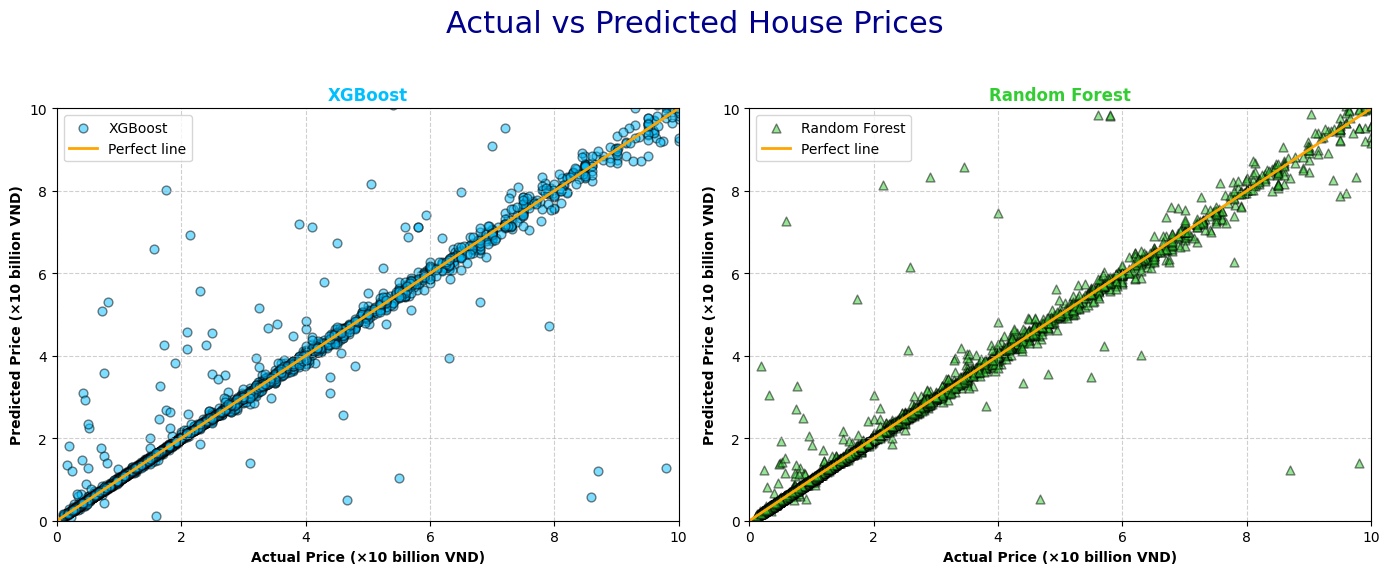

In [48]:
# -------------------------------------------------
# 8. MINH HỌA SCATTER ACTUAL vs PREDICTED
# -------------------------------------------------
import matplotlib.pyplot as plt

# Giả sử bạn đã có biến rf_pred  (kết quả Random Forest)
models = [("XGBoost", xgb_pred, "deepskyblue", "o"),
          ("Random Forest", rf_pred, "limegreen",   "^")]

plt.figure(figsize=(14,6))
for i, (name, pred, color, marker) in enumerate(models, 1):
    plt.subplot(1,2,i)
    plt.scatter(y_test/10, pred/10, c=color, marker=marker,
                s=40, edgecolors="black", alpha=0.5, label=name)
    plt.plot([0,10], [0,10], "orange", lw=2, label="Perfect line")
    plt.xlim(0,10); plt.ylim(0,10)
    plt.xlabel("Actual Price (×10 billion VND)", fontweight="bold")
    plt.ylabel("Predicted Price (×10 billion VND)", fontweight="bold")
    plt.title(name, fontweight="bold", color=color)
    plt.grid(ls="--", alpha=0.6); plt.legend()

plt.suptitle("Actual vs Predicted House Prices", fontsize=22, color="darkblue")
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

In [49]:
# -------------------------------------------------
# 9. IMPORT THƯ VIỆN
# -------------------------------------------------
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import (mean_squared_error,
                             mean_squared_log_error, r2_score)
import numpy as np

In [50]:
# -------------------------------------------------
# 10. BASE MODEL (đều bọc trong pipeline có 'prep')
# -------------------------------------------------
xgb_pipe = Pipeline([
        ("prep", preprocess),
        ("xgb",  XGBRegressor(**study.best_params))
])

rf_pipe = Pipeline([
        ("prep", preprocess),
        ("rf",   RandomForestRegressor(**study.best_params))
])

In [51]:
# -------------------------------------------------
# 11. META‑MODEL  (RidgeCV cho chắc chắn)
# -------------------------------------------------
meta_model = RidgeCV(alphas=np.logspace(-3,3,13))

In [52]:
# -------------------------------------------------
# 12. STACKING REGRESSION  (K=10 fold, shuffle)
# -------------------------------------------------
stack = StackingRegressor(
        estimators=[('xgb', xgb_pipe),
                    ('rf', rf_pipe)],
        final_estimator=meta_model,
        cv=KFold(n_splits=10, shuffle=True, random_state=42),
        n_jobs=-1,
        passthrough=False    # chỉ dùng dự báo base model
)

In [53]:
# -------------------------------------------------
# 13. HUẤN LUYỆN
# -------------------------------------------------
stack.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [19:56:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
[19:59:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[19:59:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[19:59:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.
[19:59:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.


[19:59:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_spl

StackingRegressor(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                  estimators=[('xgb',
                               Pipeline(steps=[('prep',
                                                ColumnTransformer(transformers=[('num',
                                                                                 StandardScaler(),
                                                                                 Index(['price_per_m2', 'area', 'floors', 'toilets', 'bedrooms', 'balcony',
       'street_frontage', 'legal', 'interior', 'year', 'month', 'day'],
      dtype='object')),
                                                                                ('bool',
                                                                                 'passthrough',
                                                                                 Index(['house_t...
                                                RandomForestRegressor(bootstrap=False,
                                                                      max_depth=21,
                                                                      max_features=0.9846272905734836,
                                                                      n_estimators=659))]))],
                  final_estimator=RidgeCV(alphas=array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])),
                  n_jobs=-1)

In [54]:
# -------------------------------------------------
# 14. ĐÁNH GIÁ DỰA TRÊN TẬP TEST
# -------------------------------------------------
pred_test = stack.predict(X_test)

rmse  = np.sqrt(mean_squared_error(y_test, pred_test))
rmsle = np.sqrt(mean_squared_log_error(
                    np.clip(y_test, 0, None)+1,
                    np.clip(pred_test, 0, None)+1))
r2    = r2_score(y_test, pred_test)

print(f"RMSE  : {rmse:,.3f}")
print(f"RMSLE : {rmsle:.3f}")
print(f"R²    : {r2:.4f}")

RMSE  : 19.336
RMSLE : 0.184
R²    : 0.8428


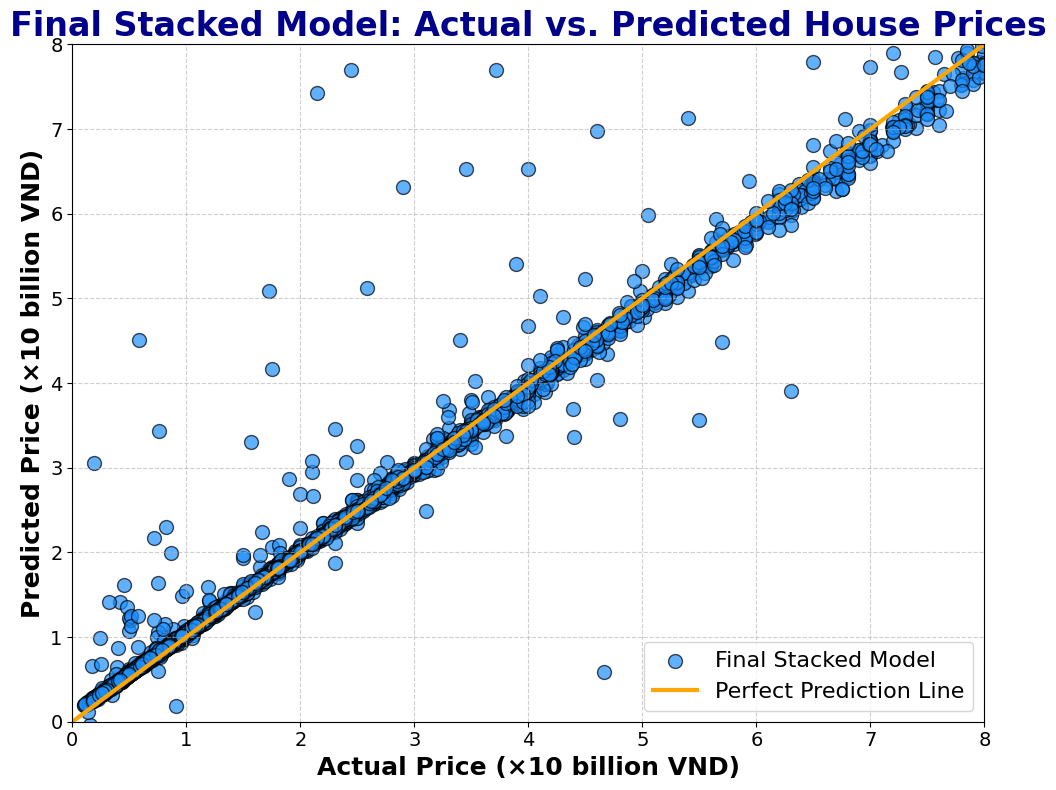

In [55]:
# -------------------------------------------------
# 15. VẼ SCATTER
# -------------------------------------------------
plt.figure(figsize=(10, 8))
plt.title("Final Stacked Model: Actual vs. Predicted House Prices", fontsize=24, fontweight='bold', color='darkblue')

plt.scatter(y_test / 10, pred_test / 10,
            color='dodgerblue', marker='o', edgecolors="black", alpha=0.7, s=100, label="Final Stacked Model")

plt.plot([0, 8], [0, 8], "orange", lw=3, label="Perfect Prediction Line")

plt.xlim(0, 8)
plt.ylim(0, 8)
plt.xlabel("Actual Price (×10 billion VND)", fontsize=18, fontweight='bold')
plt.ylabel("Predicted Price (×10 billion VND)", fontsize=18, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower right", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
import joblib

MODEL_PATH = "Stack_model_Rf+Xgb.joblib"

# Lưu toàn bộ pipeline/mô hình
joblib.dump(stack, MODEL_PATH, compress=3)

print("Saved model: Stack_model_Rf+Xgb.joblib")

Saved model: Stack_model_Rf+Xgb.joblib


In [57]:
# -------------------------------------------------
# 16. TRIỂN KHAI
# -------------------------------------------------
deploy_pred = stack.predict(X_test)
pd.DataFrame({"Price": deploy_pred}) \
  .to_csv("Submission_Stack_(Xgb+Rf).csv", index=False)

print("Saved file: Submission_Stack_(Xgb+Rf).csv")

Saved file: Submission_Stack_(Xgb+Rf).csv
